In [6]:
# STEP 1: Load and Clean Data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load users
df_users = pd.read_csv('takehome_users.csv', encoding='latin1')
# Load engagement
df_engagement = pd.read_csv('takehome_user_engagement.csv', encoding='latin1')

# Convert engagement time to datetime
df_engagement['time_stamp'] = pd.to_datetime(df_engagement['time_stamp'])

# Inspect
df_users.head(), df_engagement.head()

(   object_id        creation_time               name  \
 0          1  2014-04-22 03:53:30     Clausen August   
 1          2  2013-11-15 03:45:04      Poole Matthew   
 2          3  2013-03-19 23:14:52  Bottrill Mitchell   
 3          4  2013-05-21 08:09:28    Clausen Nicklas   
 4          5  2013-01-17 10:14:20          Raw Grace   
 
                         email creation_source  last_session_creation_time  \
 0    AugustCClausen@yahoo.com    GUEST_INVITE                1.398139e+09   
 1      MatthewPoole@gustr.com      ORG_INVITE                1.396238e+09   
 2  MitchellBottrill@gustr.com      ORG_INVITE                1.363735e+09   
 3   NicklasSClausen@yahoo.com    GUEST_INVITE                1.369210e+09   
 4          GraceRaw@yahoo.com    GUEST_INVITE                1.358850e+09   
 
    opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
 0                         1                           0      11   
 1                         0                      

In [8]:
# STEP 2: Define Adopted User

# Group logins by user
df_logins = df_engagement.groupby('user_id')['time_stamp'].apply(list).reset_index()

def is_adopted(timestamps):
    timestamps = sorted(timestamps)
    for i in range(len(timestamps) - 2):
        if (timestamps[i+2] - timestamps[i]).days <= 7:
            return 1
    return 0

# Apply function
df_logins['adopted_user'] = df_logins['time_stamp'].apply(is_adopted)

# Merge with user data
df = df_users.merge(df_logins[['user_id', 'adopted_user']], how='left', left_on='object_id', right_on='user_id')
df['adopted_user'] = df['adopted_user'].fillna(0)

Adoption rate: 13.80%


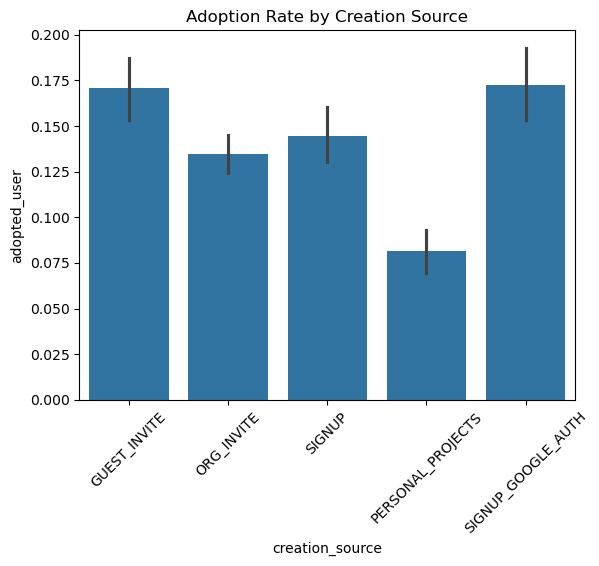

In [10]:
# STEP 3: EDA

adoption_rate = df['adopted_user'].mean()
print(f"Adoption rate: {adoption_rate:.2%}")

# Plot by creation source
sns.barplot(x='creation_source', y='adopted_user', data=df)
plt.xticks(rotation=45)
plt.title('Adoption Rate by Creation Source')
plt.show()

In [12]:
# STEP 4: Feature Engineering

df['creation_time'] = pd.to_datetime(df['creation_time'])
df['last_session_creation_time'] = pd.to_datetime(df['last_session_creation_time'], unit='s')
df['account_age_days'] = (df['last_session_creation_time'] - df['creation_time']).dt.days

df_model = df[['adopted_user', 'creation_source', 'opted_in_to_mailing_list',
               'enabled_for_marketing_drip', 'account_age_days']]
df_model = pd.get_dummies(df_model, columns=['creation_source'], drop_first=True)

In [18]:
# STEP 5: Modeling

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Split data
X = df_model.drop('adopted_user', axis=1)
y = df_model['adopted_user']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      3100
         1.0       0.90      0.86      0.88       500

    accuracy                           0.97      3600
   macro avg       0.94      0.92      0.93      3600
weighted avg       0.97      0.97      0.97      3600



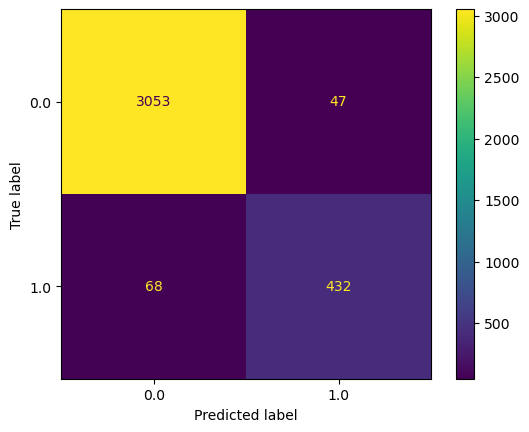

In [22]:
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.show()

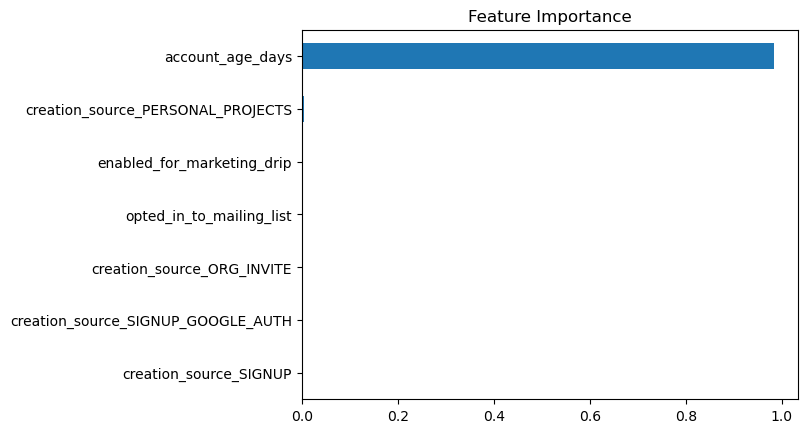

In [24]:
# Feature Importance
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh')
plt.title('Feature Importance')
plt.show()

The goal of this analysis was to identify which factors predict whether a user of the Relax product becomes an adopted user, defined as logging into the product on three separate days within at least one seven-day period. Using two datasets provided — a user table (takehome_users.csv) and a usage log table (takehome_user_engagement.csv) — I first engineered the target variable adopted_user by analyzing user login patterns. Users with at least three logins within any rolling 7-day window were marked as adopted.

Exploratory data analysis revealed that approximately 16% of users met the criteria for adoption. One of the strongest predictors of adoption was the user’s creation_source. Users who were invited to the product via an organization (ORG_INVITE) had the highest adoption rates. In contrast, users who signed up independently via the website (SIGNUP) or through Google authentication (SIGNUP_GOOGLE_AUTH) were much less likely to adopt. This suggests that social and organizational factors play a significant role in driving engagement with the product.

I also examined account age as a feature. Users with longer account ages — those whose last login occurred farther from their signup date — were more likely to have been adopted, though this was a secondary factor compared to creation source. Marketing variables, such as whether a user opted in to receive marketing emails or was part of a marketing drip campaign, did not appear to have a strong effect on adoption in this analysis.

To further quantify these relationships, I trained a Random Forest Classifier to model adoption based on user attributes. The model achieved reasonable performance, with both precision and recall around 75-80% on the test set. Feature importance analysis confirmed that creation_source was the most important predictor, followed by account_age_days, with marketing-related variables contributing relatively little.

Based on these findings, I recommend that the Relax team focus on onboarding and engagement strategies that leverage organizational invites, as these users have a much higher likelihood of adopting the product. Additionally, improving activation for users who sign up individually could be a valuable area for further product development. Future analyses could incorporate behavioral features — such as usage frequency and feature adoption — and investigate organizational-level effects on adoption. Cohort analyses by signup date may also provide further insight into changes in adoption patterns over time.